## Comparison between ICESat-2 and Sentinel-2

In [1]:
from IPython.display import clear_output
import time 

#for i in range(10):
#    clear_output(wait=True)
#    print(i)
#    time.sleep(1)

In [2]:
import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show

import datetime as dt
import pandas as pd

import numpy as np
import glob, os

# make sure we're dealing with the most recent version of any code we're using
%load_ext autoreload
%autoreload 2

#from readers.get_ATL10 import get_ATL10data
#from readers.getATL07 import get_ATL07

In [3]:
import warnings
import h5py
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py
import scipy
# from astropy.time import Time

def convert_time(delta_time):
    times = []
    years = []
    months = []
    days = []
    hours = []
    minutes = []
    seconds =[]
    
    for i in range(0, len(delta_time)):
        times.append(dt.datetime(1980, 1, 6) + dt.timedelta(seconds = delta_time[i]))
        years.append(times[i].year)
        months.append(times[i].month)
        days.append(times[i].day)
        hours.append(times[i].hour)
        minutes.append(times[i].minute)
        seconds.append(times[i].second)
    
    temp = pd.DataFrame({'time':times, 'year': years, 'month': months, 'day': days,
                         'hour': hours, 'minute': minutes, 'second': seconds
                        })
    return temp

# Function to calculate the photon rate (photons / shots(pulses))
def count_pid(pid, conf, conf_th = 3):
    idcount = np.zeros(len(pid))
    idcount2 = np.zeros(len(pid))
    firstid = pid[0]
    
    count = 0
    count2 = 0
    
    for i in range(0, len(pid)):
        if pid[i] == firstid:
            count += 1
            if conf[i] >= conf_th:
                count2 += 1
        else:
            idcount[i-count:i] = count
            idcount2[i-count:i] = count2
            firstid = pid[i]
            count = 1
            if conf[i] >= conf_th:
                count2 = 1
            else:
                count2 = 0
        
    return idcount, idcount2

# Function to calculate the background count and background rate
def cal_bckgrd(pid, frame_cnt, bck_pce0, bck_cnt0, bck_rate0):
    bck_cnt1 = np.zeros(len(pid))
    bck_rate1 = np.zeros(len(pid))

    frames, idx = np.unique(bck_pce0, return_index=True)
    
    for i in range(0, len(pid)):      
        
        idx0 = idx[np.argmin(abs(frames - frame_cnt[i]))]
    
        v = (pid[i]-1) // 50
        bck_cnt1[i] = bck_cnt0[idx0 + v]
        bck_rate1[i] = bck_rate0[idx0 + v]

#     for frame in frames:
#         idx0 = np.where(frame_cnt == frame)[0][0]
#         pid_part = pid[frame_cnt == frame]
#         bcnt_part = bck_cnt[bck_pce == frame]
#         brate_part = bck_rate[bck_pce == frame]

#         n = 0
#         for j in range(0, 4):
#             idx1 = np.where((pid_part >= j*50+1) & (pid_part <= (j+1)*50))[0]
#             if len(idx1) > 0:
#                 bck_cnt1[idx0+idx1[0]:idx0+idx1[-1]+1] = bcnt_part[min(n, len(bcnt_part)-1)]
#                 bck_rate1[idx0+idx1[0]:idx0+idx1[-1]+1] = brate_part[min(n, len(bcnt_part)-1)]
#                 n+=1
                
    return bck_cnt1, bck_rate1

# Function to read ATL03 data (.h5 format)
def getATL03(fname, beam_number, bbox, stype = 2):
    # 0, 2, 4 = Strong beam; 1, 3, 5 = weak beam
    # sfype: surface type (0=land, 1=ocean , 2=sea ice, 3=land ice, 4=inland water)
    
    f = h5py.File(fname, 'r')
    
    orient = f['orbit_info']['sc_orient'][:]  # orientation - 0: backward, 1: forward, 2: transition
    
    if len(orient) > 1:
        print('Transitioning, do not use for science!')
        return [[] for i in beamlist]
    elif (orient == 0):
        beams=['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']                
    elif (orient == 1):
        beams=['gt3r', 'gt3l', 'gt2r', 'gt2l', 'gt1r', 'gt1l']
    # (strong, weak, strong, weak, strong, weak)
    # (beam1, beam2, beam3, beam4, beam5, beam6)

    beam = beams[beam_number]    
    
    try:
        # height of each received photon, relative to the WGS-84 ellipsoid
        # (with some, not all corrections applied, see background info above)
        heights=f[beam]['heights']['h_ph'][:]
        # latitude (decimal degrees) of each received photon
        lats=f[beam]['heights']['lat_ph'][:]
        # longitude (decimal degrees) of each received photon
        lons=f[beam]['heights']['lon_ph'][:]
        # seconds from ATLAS Standard Data Product Epoch. use the epoch parameter to convert to gps time
        deltatime=f[beam]['heights']['delta_time'][:]
    except:
        return pd.DataFrame({})   
    
    if bbox != None:
        if bbox[0] < bbox[2]:
            valid = (lats >= bbox[1]) & (lats <= bbox[3]) & (lons >= bbox[0]) & (lons <= bbox[2])
        else:
            valid = (lats >= bbox[1]) & (lats <= bbox[3]) & ((lons >= bbox[0]) | (lons <= bbox[2]))
    
    if len(heights[valid]) == 0:
        return pd.DataFrame({})    
    else:
        # Surface types for signal classification confidence
        # 0=Land; 1=Ocean; 2=SeaIce; 3=LandIce; 4=InlandWater    
        conf=f[beam]['heights']['signal_conf_ph'][:, stype] #choose column 2 for confidence of sea ice photons
        # confidence level associated with each photon event
        # -2: TEP
        # -1: Events not associated with a specific surface type
        #  0: noise
        #  1: buffer but algorithm classifies as background
        #  2: low
        #  3: medium
        #  4: high
        # number of ATL03 20m segments
        n_seg, = f[beam]['geolocation']['segment_id'].shape
        # first photon in the segment (convert to 0-based indexing)
        Segment_Index_begin = f[beam]['geolocation']['ph_index_beg'][:] - 1
        # number of photon events in the segment
        Segment_PE_count = f[beam]['geolocation']['segment_ph_cnt'][:]
        # along-track distance for each ATL03 segment
        Segment_Distance = f[beam]['geolocation']['segment_dist_x'][:]
        # along-track distance (x) for photon events
        x_atc = np.array(f[beam]['heights']['dist_ph_along'][:])
        # cross-track distance (y) for photon events
        y_atc = np.array(f[beam]['heights']['dist_ph_across'][:])
        # The photon event counter is part of photon ID and counts from 1 for each channel until reset by laser pulse counter
        pulse_id = f[beam]['heights']['ph_id_pulse'][:]
        frame_cnt = f[beam]['heights']['pce_mframe_cnt'][:]
        # pcount: number of the returned photon that has the same pulse id
        pulse_cnt, pulse_cnth = count_pid(pulse_id, conf)
        # pulse_cnt: photon rate (photons/pulse); pulse_cnth: photon rate for high confidence photons

        ph_id_count = f[beam]['heights']['ph_id_count'][:]

        # Calculate background factors
        bck_pce0 = f[beam]['bckgrd_atlas']['pce_mframe_cnt'][:]
        bck_cnt0 = f[beam]['bckgrd_atlas']['bckgrd_counts'][:]
        bck_rate0 = f[beam]['bckgrd_atlas']['bckgrd_rate'][:]    
        bck_cnt, bck_rate = cal_bckgrd(pulse_id, frame_cnt, bck_pce0, bck_cnt0, bck_rate0)
        del bck_pce0, bck_cnt0, bck_rate0

        # Remove the uneffective reference photons (no geo-correction parameters)
        mask_ind = (Segment_Index_begin >= 0)
        Segment_Index_begin = Segment_Index_begin[mask_ind]
        Segment_PE_count = Segment_PE_count[mask_ind]
        n_seg = len(Segment_PE_count)

        # Geographical correction parameters (refer to the ATL03 documents)
        seg_lat = f[beam]['geolocation/reference_photon_lat'][mask_ind]

        dac0 = f[beam]['geophys_corr/dac'][mask_ind]
        dac0[dac0 > 3e+38] = np.nan
        geoid0 = f[beam]['geophys_corr/geoid'][mask_ind]
        geoid0[geoid0 > 3e+38] = np.nan

        tide_earth = f[beam]['geophys_corr/tide_earth'][mask_ind]
        tide_earth[tide_earth > 3e+38] = np.nan
        tide_load = f[beam]['geophys_corr/tide_load'][mask_ind]
        tide_load[tide_load > 3e+38] = np.nan
        tide_oc = f[beam]['geophys_corr/tide_ocean'][mask_ind]
        tide_oc[tide_oc > 3e+38] = np.nan
        tide_pole = f[beam]['geophys_corr/tide_pole'][mask_ind]
        tide_pole[tide_pole > 3e+38] = np.nan
        tide_oc_pole = f[beam]['geophys_corr/tide_oc_pole'][mask_ind]
        tide_oc_pole[tide_oc_pole > 3e+38] = np.nan
        tide_eq = f[beam]['geophys_corr/tide_equilibrium'][mask_ind]
        tide_eq[tide_eq > 3e+38] = np.nan
        tide0 = tide_earth + tide_load + tide_oc + tide_pole + tide_oc_pole + tide_eq

        sea0 = f[beam]['geolocation/solar_elevation'][mask_ind] # Solar elevation angle
        sea0[sea0 > 3e+38] = np.nan
        saa0 = f[beam]['geolocation/solar_azimuth'][mask_ind] # Solar azimuth angle
        saa0[saa0 > 3e+38] = np.nan

        # Remove unaffective geo-correction values
        dac0 = dac0[tide0 != np.nan]
        geoid0 = geoid0[tide0 != np.nan]
        sea0 = sea0[tide0 != np.nan]
        saa0 = saa0[tide0 != np.nan]
        tide0 = tide0[tide0 != np.nan]
        seg_lat = seg_lat[tide0 != np.nan]

        # Since the number of reference points are less than the original photons,
        # reference heights of all photons should be interpolated from the existing reference points
        dac = np.interp(lats, seg_lat, dac0)
        geoid = np.interp(lats, seg_lat, geoid0)
        tide = np.interp(lats, seg_lat, tide0)
        sea = np.interp(lats, seg_lat, sea0)
        saa = np.interp(lats, seg_lat, saa0)

        del dac0, geoid0, tide0, sea0, saa0
        
        # Along track distance = x_atc
        for j in range(n_seg):
            # index for 20m segment j
            idx = Segment_Index_begin[j]
            # number of photons in 20m segment
            cnt = Segment_PE_count[j]
            # add segment distance to along-track coordinates
            x_atc[idx:idx+cnt] += Segment_Distance[j]   

        # Delta time to gps seconds
        atlas_epoch=f[beam]['/ancillary_data/atlas_sdp_gps_epoch'][0]
        temp = convert_time(deltatime + atlas_epoch)

        df03=pd.DataFrame({'beam': beam, 'lat':lats, 'lon':lons, 'x':x_atc, 'y':y_atc,
                           'height':heights, 'dac': dac, 'geoid': geoid, 'tide': tide,
                           's_azi': saa, 's_ele': sea, 
                           'deltatime':deltatime, 'conf':conf,
                           'pid': pulse_id, 'pcnt': pulse_cnt, 'pcnth': pulse_cnth,
                           'bcnt': bck_cnt, 'brate': bck_rate
                          })

        # Concatenate ATL03 dataframe and time dataframe
        df03 = pd.concat([df03, temp], axis=1).reset_index(drop = True)

        if bbox != None:
            df03 = df03[df03['lat'] >= bbox[1]].reset_index(drop = True)
            df03 = df03[df03['lat'] <= bbox[3]].reset_index(drop = True)
            if bbox[0] < bbox[2]:
                df03 = df03[df03['lon'] >= bbox[0]].reset_index(drop = True)
                df03 = df03[df03['lon'] <= bbox[2]].reset_index(drop = True)
            else:
                df03 = df03[(df03['lon'] >= bbox[0]) | (df03['lon'] <= bbox[2])].reset_index(drop = True)

        return df03

## Autolabeling -> thin cloud shadow filtered color seg

In [4]:
def plot_image(image_1, image_2,title_1="Orignal",title_2="New Image"):
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
    plt.title(title_1)
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
    plt.title(title_2)
    plt.show()

In [5]:
def plot_image3(image_1, image_2, image_3, title_1="Orignal",title_2="New Image 1", title_3 = "New Image 2"):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
    plt.title(title_1)
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
    plt.title(title_2)
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB))
    plt.title(title_3)
    plt.show()

In [6]:
def color_segmentation(img):
    # Get a "mask" over the image for each pixel
    # if a pixel's color is between the lower and upper white, its mask is 1
    # Otherwise, the pixel's mask is 0
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    lower_ice = (0, 0, 205)#(127, 7, 94) #increase v to specify ow
    upper_ice = (185, 255, 255)#(147, 53, 232) #increase h to specify si
    mask_ice = cv2.inRange(hsv_img, lower_ice, upper_ice)
    
    lower_tice = (0, 0, 31)#(127, 7, 94) #increase v to specify ow
    upper_tice = (185, 255, 204)#(147, 53, 232) #increase h to specify si
    mask_tice = cv2.inRange(hsv_img, lower_tice, upper_tice)
    
    lower_water = (0, 0, 0)#(127, 7, 94) #increase v to specify ow
    upper_water = (185, 255, 30)#(147, 53, 232) #increase h to specify si
    mask_water = cv2.inRange(hsv_img, lower_water, upper_water)
    
    # duplicate the image
    seg_img = img.copy()
    #color each masked portion
    seg_img[mask_ice == 255] = [255, 0, 0]
    seg_img[mask_tice == 255] = [0, 0, 255]
    seg_img[mask_water == 255] = [0, 255, 0]
    
    #seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
    
    return seg_img

In [7]:
def shadow_cloud_removal(ori):

    ### seperate open water
    lower_water = (0, 0, 0)
    upper_water = (185, 255, 30)
    hsv_img = cv2.cvtColor(ori, cv2.COLOR_RGB2HSV)
    mask_water = (cv2.inRange(hsv_img, lower_water, upper_water))

    # duplicate the image
    without_water_img = ori.copy()
    without_water_img[mask_water == 255] = [255, 255, 255]
    #plot_image(ori, water_img)

    #img = cv2.imread('s2_vis_2.png',cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(without_water_img, cv2.COLOR_RGB2GRAY)

    dilated_img = cv2.dilate(img, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 155)
    diff_img = 255 - cv2.absdiff(img, bg_img)

    ret2, outs2 = cv2.threshold(src = diff_img, thresh = 0, maxval = 255, type = cv2.THRESH_OTSU+cv2.THRESH_BINARY)
    diff_img2 = cv2.bitwise_and(diff_img, outs2)

    norm_img = cv2.normalize(diff_img2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    _, thr_img = cv2.threshold(norm_img, 235, 0, cv2.THRESH_TRUNC)
    thr_img = cv2.normalize(thr_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

    ### seperate thin and old ice
    old_thin_ice = cv2.cvtColor(thr_img,cv2.COLOR_GRAY2RGB)
    hsv_img = cv2.cvtColor(old_thin_ice, cv2.COLOR_RGB2HSV)

    lower_tice = (0, 0, 0)
    upper_tice = (185, 255, 204)
    mask_tice = cv2.inRange(hsv_img, lower_tice, upper_tice)

    lower_ice = (0, 0, 205)
    upper_ice = (185, 255, 255)
    mask_ice = cv2.inRange(hsv_img, lower_ice, upper_ice)
    mask_ice = cv2.bitwise_xor(mask_water, mask_ice)
    #plot_image3(mask_water, mask_tice, mask_ice)

    # duplicate the image
    shadow_free = old_thin_ice.copy()
    #color each masked portion
    shadow_free[mask_ice == 255] = [255, 255, 255]
    shadow_free[mask_tice == 255] = [155, 155, 155]
    shadow_free[mask_water == 255] = [0, 0, 0]
    shadow_free = cv2.cvtColor(shadow_free, cv2.COLOR_BGR2RGB)
    #plot_image(shadow_free, ori)

    #segmentation
    #img = cv2.cvtColor(water_img,cv2.COLOR_GRAY2RGB)
    seg_img = color_segmentation(ori)
    #plot_image(ori, seg_img, title_1 = "Original Image", title_2 = "Segmented original image")

    #final = cv2.cvtColor(shadow_free,cv2.COLOR_GRAY2RGB)
    seg_res = color_segmentation(shadow_free)
    #gray = cv2.cvtColor(seg_res,cv2.COLOR_RGB2GRAY)
    #plot_image(shadow_free, seg_res, title_1 = "Shadow free Image", title_2 = "Segmented shadow free image")
    
    #return seg_img, shadow_free, seg_res
    return seg_res
        

In [8]:
def rgba2rgb( rgba, background=(0,0,0)):
    row, col, ch = rgba.shape
    if ch == 3:
        return rgba
    assert ch == 4, 'RGBA image has 4 channels.'
    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    a = np.asarray( a, dtype='float32' ) / 255.0
    R, G, B = background
    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B
    return np.asarray( rgb, dtype='uint8' )

In [9]:
## Import the library OpenCV
#from rembg import remove
#import cv2
#
#file_name = "s2_tiff/s2_vis_00_20191103T183459_20191103T183502_T05CMR.tif"
#img = rasterio.open(file_name, crs = 'EPSG:3976')
#
#ori = img.read()
#ori[ori < 0] = 0
#ori = ori.swapaxes(0,1)
#ori = ori.swapaxes(1,2)
#img_array = shadow_cloud_removal(ori)
#
##tmp = cv2.cvtColor(ori, cv2.COLOR_BGR2GRAY)
##_, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
###r, g, b = cv2.split(img_array)
##b, g, r = cv2.split(img_array)
##b, g, r = cv2.split(ori)
##
##rgba = [b, g, r, alpha]
##dst = cv2.merge(rgba, 4)
#
#
##dst = rgba2rgb(dst, background=(0,0,0))
#
#
#img_array = remove(img_array)
#dst = rgba2rgb(img_array, background=(0,0,0))
#
#plt.figure(figsize=(20,20))
#plt.imshow(dst)
#plt.title("Original Image")
##plt.colorbar()
#plt.show()



In [10]:
path1 = os.path.abspath('../')
path_ATL03 = os.path.join(path1, "IS2_LSTM")
path_s2 = os.path.join(path1, "S2_tif")
path_csv = os.path.join(path1, "csv")
path_before_training = os.path.join(path1, "Before_training")
print(path_s2)

/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/S2_tif


## Autolabeling IS2 with S2 all

In [11]:
# %pip uninstall numpy -y
from rembg import remove
import cv2

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:

import time
import geopandas as gpd


file = 's2_tiff/s2_vis_16_T02CNV_32702.tif' #glob.glob(path + "*_label.tif")[1]
filelist = sorted(glob.glob(os.path.join(path_s2, "*.tif")))

for file in filelist:
    t0 = time.time()
    img = rasterio.open(file, crs='EPSG:3976')

    raw = img.read(1)
    raw[raw < 0] = 0

    ori = img.read()
    ori[ori < 0] = 0
    ori = ori.swapaxes(0, 1)
    ori = ori.swapaxes(1, 2)

    img_array = shadow_cloud_removal(ori)
    img_array[img_array < 0] = 0
    img_array = remove(img_array)
    img_array = rgba2rgb(img_array, background=(0, 0, 0)) 
    
    height = img_array.shape[0]
    width = img_array.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(img.transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)
    print(xs.shape)

    imgfile = os.path.basename(file)[10:-4]
    list03 = pd.read_csv(os.path.join(path1, "ATL03_S2_2019-11-01_2019-11-30_ross.csv"))
    print("list03", list03)
    atlfilepath = path_csv
    atlfile = list03[list03['S2_id'] == "COPERNICUS/S2_SR/" + imgfile]['IS2_file'].values[0][:-9]

    df_gt1r = pd.DataFrame()
    df_gt2r = pd.DataFrame()
    df_gt3r = pd.DataFrame()

    altfile_gt1r = os.path.join(atlfilepath, atlfile + "gt1r.csv")
    if os.path.isfile(altfile_gt1r):
        df_gt1r = pd.read_csv(altfile_gt1r)
        print(altfile_gt1r)

    altfile_gt2r = os.path.join(atlfilepath, atlfile + "gt2r.csv")
    if os.path.isfile(altfile_gt2r):
        df_gt2r = pd.read_csv(altfile_gt2r)
        print(altfile_gt2r)

    altfile_gt3r = os.path.join(atlfilepath, atlfile + "gt3r.csv")
    if os.path.isfile(altfile_gt3r):
        df_gt3r = pd.read_csv(altfile_gt3r)
        print(altfile_gt3r)

    df0 = pd.concat([df_gt1r, df_gt2r, df_gt3r])
    # show the first few rows
    print('Head here', df0.head())
    df0 = df0.reset_index(drop=True)

    if 'x' in df0.columns:
        df0['x_atc'] = df0['x']
        df0.drop(['x'], axis=1, inplace=True)

    gdf = gpd.GeoDataFrame(df0, geometry=gpd.points_from_xy(df0.lon, df0.lat))
    gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    gdf = gdf.to_crs('epsg:3976')

    gdf['x'] = gdf.geometry.apply(lambda x: x.x)
    gdf['y'] = gdf.geometry.apply(lambda x: x.y)

    df = pd.DataFrame(gdf)

    x_min = xs.min()
    x_max = xs.max()
    y_min = ys.min()
    y_max = ys.max()

    df = df[(df["x"] >= x_min) & (df["x"] <= x_max) & (df["y"] >= y_min) & (df["y"] <= y_max)]

    idx = []
    for x, y in zip(df["x"], df["y"]):
        idx.append(img.index(x, y))

    df["pix_x"] = idx[1]
    df["pix_y"] = idx[0]

    rgb_array = img_array[idx[0], idx[1]]
    rgb_array[:, [2, 1]] = rgb_array[:, [1, 2]]
    
    df["label"] = np.nan
    df["argmax"] = np.argmax(rgb_array, axis=1)
    df["max"] = rgb_array.max(axis=1)
    df["label"] = df.argmax.loc[df['max'] > 0]
    df = df.drop(columns=['argmax', 'max'])
    
    label_path = "ATL03_labeled_data/"
    print(label_path + atlfile + imgfile[-6:] + "_" + "labeled.csv")
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(ori, cv2.COLOR_BGR2RGB))
    plt.scatter(df["pix_x"], df["pix_y"], c=df["label"], s=1, cmap="jet")
    plt.title("Original image")
    plt.subplot(1, 2, 2)
    plt.imshow(img_array, cmap="gray")
    plt.scatter(df["pix_x"], df["pix_y"], c=df["label"], s=1, cmap="jet")
    plt.title("Segmented image")
    plt.show()

    break

    t1 = time.time()
    total = t1 - t0
    print("time is ", total)

#date = dt.datetime.strptime(os.path.basename(file)[10:18], "%Y%m%d")
#date

(233733120,)
list03     Unnamed: 0                                 IS2_file  \
0            0  ATL03_20191103184432_05780510_006_01.h5   
1            1  ATL03_20191103184432_05780510_006_01.h5   
2            2  ATL03_20191103184432_05780510_006_01.h5   
3            3  ATL03_20191103184432_05780510_006_01.h5   
4            4  ATL03_20191104195311_05940510_006_01.h5   
..         ...                                      ...   
60          60  ATL03_20191126182014_09290510_006_01.h5   
61          61  ATL03_20191126182014_09290510_006_01.h5   
62          62  ATL03_20191126182014_09290510_006_01.h5   
63          63  ATL03_20191126182014_09290510_006_01.h5   
64          64  ATL03_20191127175434_09440510_006_01.h5   

                                                S2_id  start_date    end_date  \
0   COPERNICUS/S2_SR/20191103T183459_20191103T1835...  2019-11-03  2019-11-04   
1   COPERNICUS/S2_SR/20191103T183459_20191103T1835...  2019-11-03  2019-11-04   
2   COPERNICUS/S2_SR/2019110

ValueError: Length of values (2) does not match length of index (230989)

In [36]:
imgfile = os.path.basename(file)[10:-4]
print("file", file)
print("imgfile", imgfile)

file /Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/S2_tif/s2_vis_00_20191103T183459_20191103T183502_T05CMR.tif
imgfile 20191103T183459_20191103T183502_T05CMR


: 

## ATL03 file by each track line

In [26]:
from rembg import remove
import cv2
import time

path = 'S2_tif/'
#file = 's2_tiff/s2_vis_16_T02CNV_32702.tif' #glob.glob(path + "*_label.tif")[1]
# filelist = sorted(glob.glob(path_s2 + "s2_vis_" + "*.tif"))
atl03_to_s2_mapping_file = pd.read_csv(os.path.join(path1, "ATL03_S2_2019-11-01_2019-11-30_ross.csv"))

filelist = sorted(glob.glob(os.path.join(path_s2, "*.tif")))

for file in filelist:
    print(file)
    t0 = time.time()
    img = rasterio.open(file, crs = 'EPSG:3976')
    
    raw = img.read(1)
    raw[raw < 0] = 0
    
    ori = img.read()
    ori[ori < 0] = 0
    ori = ori.swapaxes(0,1)
    ori = ori.swapaxes(1,2)

    img_array = shadow_cloud_removal(ori)
    img_array[img_array < 0] = 0
    img_array = remove(img_array)
    img_array = rgba2rgb(img_array, background=(0,0,0)) 
    
    height = img_array.shape[0]
    width = img_array.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(img.transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)
    print(xs.shape)  
    
    imgfile = os.path.basename(file)[10:-4]
    list03 = atl03_to_s2_mapping_file

    atlfilepath = path_csv
    atlfile = list03[list03['S2_id'] == "COPERNICUS/S2_SR/"+imgfile]['IS2_file'].values[0][:-9]
    
    df_gt1r = pd.DataFrame()
    df_gt2r = pd.DataFrame()
    df_gt3r = pd.DataFrame()
    
    altfile_gt1r = os.path.join(atlfilepath, atlfile + "gt1r.csv")
    if os.path.isfile(altfile_gt1r):
        df_gt1r = pd.read_csv(altfile_gt1r)
        print(altfile_gt1r)
    
    altfile_gt2r = atlfilepath + atlfile + "gt2r.csv"
    if os.path.isfile(altfile_gt2r):
        df_gt2r = pd.read_csv(altfile_gt2r)
        print(altfile_gt2r)
    
    altfile_gt3r = atlfilepath + atlfile + "gt3r.csv"
    if os.path.isfile(altfile_gt3r):
        df_gt3r = pd.read_csv(altfile_gt3r)
        print(altfile_gt3r)
    
    #df0 = df_gt1r.append(df_gt2r).append(df_gt3r)
    #df0 = df0.reset_index(drop=True)
    
    beam_list = ["gt1r", "gt2r", "gt3r"]
    #break
    for bl in beam_list:
        
        if(bl == "gt1r"):
            df0 = df_gt1r.copy()
        if(bl == "gt2r"):
            df0 = df_gt2r.copy()
        if(bl == "gt3r"):
            df0 = df_gt3r.copy()
        
        if df0.empty:
            print('DataFrame is empty!')
            continue
            
        df0 = df0.reset_index(drop=True)
        
        df0['x_atc'] = df0['x']
        df0.drop(['x'], axis = 1)

        gdf = geopandas.GeoDataFrame(df0, geometry=geopandas.points_from_xy(df0.lon, df0.lat))
        gdf.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
        gdf = gdf.to_crs('epsg:3976')

        gdf['x'] = gdf.geometry.apply(lambda x: x.x)
        gdf['y'] = gdf.geometry.apply(lambda x: x.y)

        df = pd.DataFrame(gdf)     

        x_min = xs.min()
        x_max = xs.max()
        y_min = ys.min()
        y_max = ys.max()

        #print(x_min, x_max, y_min, y_max)
        df = df[(df["x"]>=x_min) & (df["x"]<=x_max) & (df["y"]>=y_min) & (df["y"]<=y_max)]
        #print(df)
        idx = [img.index(x, y) for x, y in zip(df['x'], df['y'])]
        # idx = img.index(df["x"], df["y"])
        df["pix_x"], df['pix_y'] = zip(*idx)
        # df["pix_y"] = idx[0]

        print("FINISH!!")

        # R G B => thick ice 0, open water 1, thin ice 2
        rgb_array = img_array[idx[0], idx[1]]
        rgb_array[:, [2, 1]] = rgb_array[:, [1, 2]]

        df["label"] = np.nan
        df["argmax"] = np.argmax(rgb_array, axis=1)
        df["max"] = rgb_array.max(axis=1)
        df["label"] = df.argmax.loc[df['max']>0]

        df = df.drop(columns=['argmax', 'max'])
        df = df[df['label'].notna()]

        label_path = "ATL03_labeled_data/"
        # save the prepared data

        print(label_path + atlfile + imgfile[-6:] + "_" + bl + "_labeled_10m.csv")
        #df.to_csv(label_path + atlfile + imgfile[-6:] + "_" + bl + "_labeled_10m.csv")

        plt.figure(figsize=(10,10))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(ori, cv2.COLOR_BGR2RGB))
        plt.scatter(df["pix_x"], df["pix_y"], c = df["label"], s=1, cmap = "jet")
        plt.title("Original image")
        plt.subplot(1, 2, 2)
        plt.imshow(img_array, cmap ="gray")
        plt.scatter(df["pix_x"], df["pix_y"], c = df["label"], s=1, cmap = "jet")
        plt.title("Segmented image")
        plt.show()
        
        plt.figure(figsize=(10,10))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(ori, cv2.COLOR_BGR2RGB))
        plt.scatter(df["pix_x"], df["pix_y"], c = df["h_cor_mean"], s=1, cmap = "jet")
        plt.title("Original image")
        plt.subplot(1, 2, 2)
        plt.imshow(img_array, cmap ="gray")
        plt.scatter(df["pix_x"], df["pix_y"], c = df["h_cor_mean"], s=1, cmap = "jet")
        plt.title("Segmented image")
        plt.show()
        
        plt.figure(figsize=(10,10))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(ori, cv2.COLOR_BGR2RGB))
        plt.scatter(df["pix_x"], df["pix_y"], c = df["h_cor_med"], s=1, cmap = "jet")
        plt.title("Original image")
        plt.subplot(1, 2, 2)
        plt.imshow(img_array, cmap ="gray")
        plt.scatter(df["pix_x"], df["pix_y"], c = df["h_cor_med"], s=1, cmap = "jet")
        plt.title("Segmented image")
        plt.show()

        del df0, df
        #----------------- end loop ----------------#

    #debug
    break
    t1 = time.time()
    total = t1-t0
    print("time is ", total)
    
print("labeling finished")


/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/S2_tif/s2_vis_00_20191103T183459_20191103T183502_T05CMR.tif
(233733120,)
/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/csv/ATL03_20191103184432_05780510_gt1r.csv
FINISH!!


ValueError: Length of values (2) does not match length of index (73503)

: 

s2_tiff/s2_vis_28_20191116T184459_20191116T184458_T02CMV.tif
(12639, 12858)
ATL03_Nov_2019_down2023/csv/ATL03_20191116192813_07770510_gt1r.csv
ATL03_Nov_2019_down2023/csv/ATL03_20191116192813_07770510_gt2r.csv
ATL03_Nov_2019_down2023/csv/ATL03_20191116192813_07770510_gt3r.csv
FINISH!!
ATL03_labeled_data/ATL03_20191116192813_07770510_T02CMV_gt1r_labeled_10m.csv


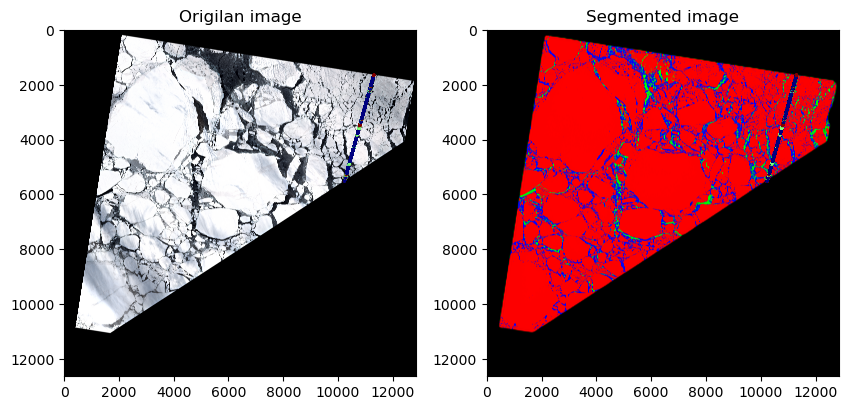

FINISH!!
ATL03_labeled_data/ATL03_20191116192813_07770510_T02CMV_gt2r_labeled_10m.csv


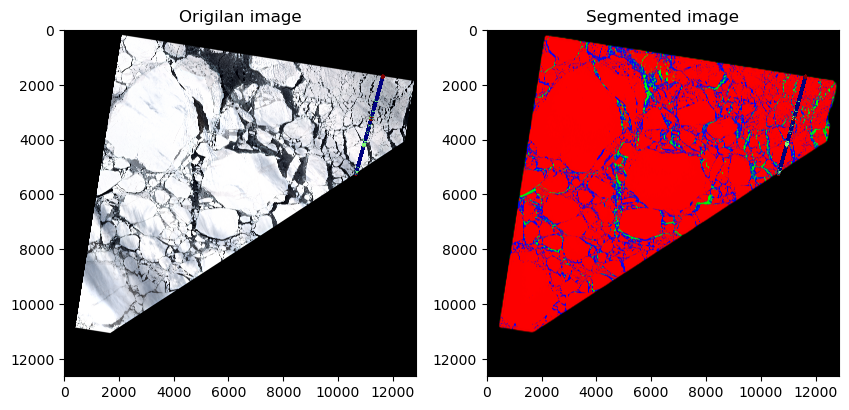

FINISH!!
ATL03_labeled_data/ATL03_20191116192813_07770510_T02CMV_gt3r_labeled_10m.csv


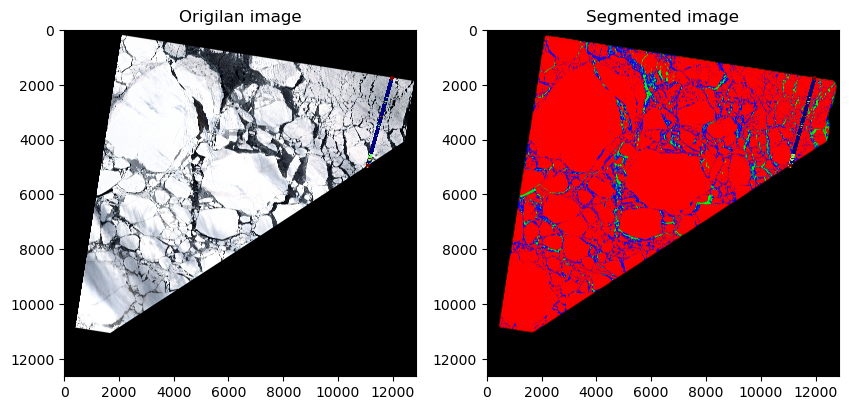

time is  145.16419339179993
labeling finished


In [18]:
from rembg import remove
import cv2
import time

path = 's2_tiff/'
#file = 's2_tiff/s2_vis_16_T02CNV_32702.tif' #glob.glob(path + "*_label.tif")[1]
filelist = sorted(glob.glob(path + "s2_vis_" + "*.tif"))
for file in filelist:
    print(file)
    t0 = time.time()
    img = rasterio.open(file, crs = 'EPSG:3976')
    
    raw = img.read(1)
    raw[raw < 0] = 0
    
    ori = img.read()
    ori[ori < 0] = 0
    ori = ori.swapaxes(0,1)
    ori = ori.swapaxes(1,2)

    img_array = shadow_cloud_removal(ori)
    img_array[img_array < 0] = 0
    img_array = remove(img_array)
    img_array = rgba2rgb(img_array, background=(0,0,0)) 
    
    height = img_array.shape[0]
    width = img_array.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(img.transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)
    print(xs.shape)  
    
    imgfile = os.path.basename(file)[10:-4]
    list03 = pd.read_csv("ATL03_S2_2019-11-01_2019-11-30_ross.csv")

    atlfilepath = "ATL03_Nov_2019_down2023/csv/"
    atlfile = list03[list03['S2_id'] == "COPERNICUS/S2_SR/"+imgfile]['IS2_file'].values[0][:-9]
    
    df_gt1r = pd.DataFrame()
    df_gt2r = pd.DataFrame()
    df_gt3r = pd.DataFrame()
    
    altfile_gt1r = atlfilepath + atlfile + "gt1r.csv"
    if os.path.isfile(altfile_gt1r):
        df_gt1r = pd.read_csv(altfile_gt1r)
        print(altfile_gt1r)
    
    altfile_gt2r = atlfilepath + atlfile + "gt2r.csv"
    if os.path.isfile(altfile_gt2r):
        df_gt2r = pd.read_csv(altfile_gt2r)
        print(altfile_gt2r)
    
    altfile_gt3r = atlfilepath + atlfile + "gt3r.csv"
    if os.path.isfile(altfile_gt3r):
        df_gt3r = pd.read_csv(altfile_gt3r)
        print(altfile_gt3r)
    
    #df0 = df_gt1r.append(df_gt2r).append(df_gt3r)
    #df0 = df0.reset_index(drop=True)
    
    beam_list = ["gt1r", "gt2r", "gt3r"]
    #break
    for bl in beam_list:
        
        if(bl == "gt1r"):
            df0 = df_gt1r.copy()
        if(bl == "gt2r"):
            df0 = df_gt2r.copy()
        if(bl == "gt3r"):
            df0 = df_gt3r.copy()
        
        if df0.empty:
            print('DataFrame is empty!')
            continue
            
        df0 = df0.reset_index(drop=True)
        
        df0['x_atc'] = df0['x']
        df0.drop(['x'], axis = 1)

        gdf = geopandas.GeoDataFrame(df0, geometry=geopandas.points_from_xy(df0.lon, df0.lat))
        gdf.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
        gdf = gdf.to_crs('epsg:3976')

        gdf['x'] = gdf.geometry.apply(lambda x: x.x)
        gdf['y'] = gdf.geometry.apply(lambda x: x.y)

        df = pd.DataFrame(gdf)     

        x_min = xs.min()
        x_max = xs.max()
        y_min = ys.min()
        y_max = ys.max()

        #print(x_min, x_max, y_min, y_max)
        df = df[(df["x"]>=x_min) & (df["x"]<=x_max) & (df["y"]>=y_min) & (df["y"]<=y_max)]
        #print(df)
        idx = img.index(df["x"], df["y"])
        df["pix_x"] = idx[1]
        df["pix_y"] = idx[0]

        print("FINISH!!")

        # R G B => thick ice 0, open water 1, thin ice 2
        rgb_array = img_array[idx[0], idx[1]]
        rgb_array[:, [2, 1]] = rgb_array[:, [1, 2]]

        df["label"] = np.nan
        df["argmax"] = np.argmax(rgb_array, axis=1)
        df["max"] = rgb_array.max(axis=1)
        df["label"] = df.argmax.loc[df['max']>0]

        df = df.drop(columns=['argmax', 'max'])
        df = df[df['label'].notna()]

        label_path = "ATL03_labeled_data/"
        # save the prepared data

        print(label_path + atlfile + imgfile[-6:] + "_" + bl + "_labeled_10m.csv")
        df.to_csv(label_path + atlfile + imgfile[-6:] + "_" + bl + "_labeled_10m.csv")

        plt.figure(figsize=(10,10))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(ori, cv2.COLOR_BGR2RGB))
        plt.scatter(df["pix_x"], df["pix_y"], c = df["label"], s=1, cmap = "jet")
        plt.title("Origilan image")
        plt.subplot(1, 2, 2)
        plt.imshow(img_array, cmap ="gray")
        plt.scatter(df["pix_x"], df["pix_y"], c = df["label"], s=1, cmap = "jet")
        plt.title("Segmented image")
        plt.show()
        
        del df0, df
        #----------------- end loop ----------------#
        
        
    #debug
    #break
    t1 = time.time()
    total = t1-t0
    print("time is ", total)
    
print("labeling finished")


## labeling correction

In [33]:
###### 10m 5km ########
import glob, os
import time

dir_path = "ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/done/"
dest_path = "ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/"
filelist = sorted(glob.glob(dir_path + "ATL03_" + "*_labeled_10m.csv"))
missing_data = 0

for file in filelist:
    print(file)
    start = time.time()
    labeled_data = pd.read_csv(file, index_col=0)   
    labeled_data = labeled_data[labeled_data['h_cor_mean'].notna()]
    labeled_data = labeled_data[(labeled_data['label'] == labeled_data['cor_label'])]
    
    #labeled_data = labeled_data.sort_values(by=['x_atc'])
    #labeled_data = labeled_data.loc[:, ~labeled_data.columns.str.contains('^Unnamed')]
    #labeled_data = labeled_data[labeled_data.h_cor_mean <= 15]
    #labeled_data = labeled_data[labeled_data['label'].notna()]
    
    nan_count = labeled_data['label'].isna().sum()   
    if(nan_count > 0):
        missing_data += nan_count
    
    #labeled_data.to_csv(file.replace(dir_path, dest_path).replace(".csv", "_cor.csv"))
    del labeled_data
    #break
    
    end = time.time() - start
    print("Time per file is ",end)
    print("MISSING DATA ",missing_data)
    print("------------ File done ------------")

print("------------ Finish ------------")    
print("filelists ",len(filelist))
#labeled_data

ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/done/ATL03_20191103184432_05780510_T05CMR_gt1r_labeled_10m.csv
Time per file is  0.39668917655944824
MISSING DATA per file is  0
------------ File done ------------
ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/done/ATL03_20191103184432_05780510_T05CMR_gt2r_labeled_10m.csv
Time per file is  0.35924506187438965
MISSING DATA per file is  0
------------ File done ------------
ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/done/ATL03_20191103184432_05780510_T05CMR_gt3r_labeled_10m.csv
Time per file is  0.3600912094116211
MISSING DATA per file is  0
------------ File done ------------
ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/done/ATL03_20191103184432_05780510_T05CMS_gt1r_labeled_10m.csv
Time per file is  0.18698644638061523
MISSING DATA per file is  0
------------ File done ------------
ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/done/ATL03_20191103184432_05780510_T05CMS_gt2r_labeled_1

In [37]:
###### 10m correction ########
import glob, os
import time

dir_path = "ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/"
dest_path = "ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/labeled_track/"

list03 = pd.read_csv("ATL03_S2_2019-11-01_2019-11-30_ross.csv")
atlfile = list03['IS2_file'].unique()
#print(atlfile)

for atl in atlfile:
    prefix = atl[:-10]
    print(prefix)
    
    labeled_data = pd.DataFrame()
    filelist1 = sorted(glob.glob(dir_path + prefix + "*_gt1r_labeled_10m_cor.csv"))
    for file in filelist1:
        print(file)
        labeled_data = labeled_data.append(pd.read_csv(file, index_col=0)) 

    #labeled_data = labeled_data.loc[:, ~labeled_data.columns.str.contains('^Unnamed')]
    #labeled_data = labeled_data[labeled_data['label'].notna()]
    #labeled_data = labeled_data.reset_index(drop=True)

    if not labeled_data.empty:
        labeled_data = labeled_data.sort_values(by=['x_atc'])
        #labeled_data.to_csv(dest_path + prefix + "_gt1r_labeled_10m.csv")
    del labeled_data


    labeled_data = pd.DataFrame()
    filelist2 = sorted(glob.glob(dir_path + prefix + "*_gt2r_labeled_10m_cor.csv"))
    for file in filelist2:
        print(file)
        labeled_data = labeled_data.append(pd.read_csv(file, index_col=0))

    #labeled_data = labeled_data.loc[:, ~labeled_data.columns.str.contains('^Unnamed')]
    #labeled_data = labeled_data[labeled_data['label'].notna()]
    #labeled_data = labeled_data.reset_index(drop=True)

    if not labeled_data.empty:
        labeled_data = labeled_data.sort_values(by=['x_atc'])
        #labeled_data.to_csv(dest_path + prefix + "_gt2r_labeled_10m.csv")
    del labeled_data


    labeled_data = pd.DataFrame()
    filelist3 = sorted(glob.glob(dir_path + prefix + "*_gt3r_labeled_10m_cor.csv"))
    for file in filelist3:
        print(file)
        labeled_data = labeled_data.append(pd.read_csv(file, index_col=0))

    
    #labeled_data = labeled_data.loc[:, ~labeled_data.columns.str.contains('^Unnamed')]
    #labeled_data = labeled_data[labeled_data['label'].notna()]
    #labeled_data = labeled_data.reset_index(drop=True)
    
    if not labeled_data.empty:
        labeled_data = labeled_data.sort_values(by=['x_atc'])
        #labeled_data.to_csv(dest_path + prefix + "_gt3r_labeled_10m.csv")
    del labeled_data

    print("------------ Finish ------------")
    print("filelists ",len(filelist1))
    print("filelists ",len(filelist2))
    print("filelists ",len(filelist3))
    break
    #labeled_data

ATL03_20191103184432_05780510
ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/ATL03_20191103184432_05780510_T05CMR_gt1r_labeled_10m_cor.csv
ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/ATL03_20191103184432_05780510_T05CMS_gt1r_labeled_10m_cor.csv
ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/ATL03_20191103184432_05780510_T05CNS_gt1r_labeled_10m_cor.csv
ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/ATL03_20191103184432_05780510_T05CNU_gt1r_labeled_10m_cor.csv
ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/ATL03_20191103184432_05780510_T05CMR_gt2r_labeled_10m_cor.csv
ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/ATL03_20191103184432_05780510_T05CMS_gt2r_labeled_10m_cor.csv
ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/ATL03_20191103184432_05780510_T05CNS_gt2r_labeled_10m_cor.csv
ATL03_labeled_data/labeled_by_is2trackline_10m_corrected/ATL03_20191103184432_05780510_T05CNU_gt2r_labeled_10m_cor.csv
ATL03_labeled_data

# Resized image batch with 32x32 with beam (lat,long) of track on the center

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window
from rasterio.transform import xy
import os
import geopandas as gpd
import glob
import random
import pandas as pd

# Define file paths
tiff_files = ['s2_vis_00_20191103T183459_20191103T183502_T05CMR.tif', 's2_vis_01_20191103T183459_20191103T183502_T05CMS.tif']


# Get list of TIFF files
tiff_files = sorted(glob.glob(os.path.join(path_s2, "*.tif")))

# Get list of CSV files
csv_files = sorted(glob.glob(os.path.join(path_csv, "*.csv")))

# Select two random CSV files
selected_csv_files = random.sample(csv_files, 2)


# Function to read coordinates from CSV
def read_coordinates_from_csv(file):
    df = pd.read_csv(file)
    # print the first 5 rows
    print(df.head())
    return list(zip(df['lat'], df['lon']))


# Read coordinates from selected CSV files
coordinates_list = []
for csv_file in selected_csv_files:
    coordinates_list.extend(read_coordinates_from_csv(csv_file))

# Show 32x32 Grid Lines and plot coordinates
for file in tiff_files[:2]:  # Process only the first two TIFF files for illustration
    img = rasterio.open(file, crs='EPSG:3976')

    raw = img.read(1)
    raw[raw < 0] = 0

    ori = img.read()
    ori[ori < 0] = 0
    ori = ori.swapaxes(0, 1)
    ori = ori.swapaxes(1, 2)

    img_array = shadow_cloud_removal(ori)
    img_array[img_array < 0] = 0
    # img_array = remove(img_array)
    # img_array = rgba2rgb(img_array, background=(0, 0, 0)) 

    height = img_array.shape[0]
    width = img_array.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(img.transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)
    print(xs.shape)

    # Convert coordinates to GeoDataFrame
    df = pd.DataFrame(coordinates_list, columns=['lat', 'lon'])
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

    # Transform to match the image's CRS
    gdf = gdf.to_crs('epsg:3976')
    
    # Extract transformed coordinates
    gdf['x'] = gdf.geometry.apply(lambda x: x.x)
    gdf['y'] = gdf.geometry.apply(lambda x: x.y)
    
    # Map coordinates to pixel indices
    pixel_coords = [img.index(x, y) for x, y in zip(gdf['x'], gdf['y'])]

    # Generate grid lines
    x_coords = np.linspace(0, width, 33)
    y_coords = np.linspace(0, height, 33)

    # Plot grid lines and coordinates
    plt.figure(figsize=(10, 10))
    plt.imshow(img_array, cmap='gray')
    for x in x_coords:
        plt.axvline(x, color='red', linewidth=0.5)
    for y in y_coords:
        plt.axhline(y, color='red', linewidth=0.5)

    # Plot coordinates
    for row_idx, col_idx in pixel_coords:
        plt.scatter(col_idx, row_idx, color='blue', s=10)

    plt.title(f'Grid Lines and Coordinates for {os.path.basename(file)}')
    plt.show()

# # Show 32x32 Grid Lines (Work on first two files only)
# for file in tiff_files[:2]:
#     with rasterio.open(file) as img:
#         width, height = img.width, img.height
#         transform = img.transform

#         # Generate grid lines
#         x_coords = np.linspace(0, width, 33)
#         y_coords = np.linspace(0, height, 33)

#         # Plot grid lines
#         plt.figure(figsize=(10, 10))
#         plt.imshow(img.read(1), cmap='gray')
#         for x in x_coords:
#             plt.axvline(x, color='red', linewidth=0.5)
#         for y in y_coords:
#             plt.axhline(y, color='red', linewidth=0.5)
#         plt.title(f'Grid Lines for {os.path.basename(file)}')
#         plt.show()

# Function to save 32x32 images
# def save_32x32_images(file, coords, output_dir):
#     with rasterio.open(file) as img:
#         # Convert coordinates to GeoDataFrame
#         df = pd.DataFrame(coords, columns=['lat', 'lon'])
#         gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
#         gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
        
#         # Transform to match the image's CRS
#         gdf = gdf.to_crs(img.crs)
        
#         # Extract transformed coordinates
#         gdf['x'] = gdf.geometry.apply(lambda x: x.x)
#         gdf['y'] = gdf.geometry.apply(lambda x: x.y)
        
#         # Map coordinates to pixel indices
#         for i, row in gdf.iterrows():
#             x, y = row['x'], row['y']
#             row_idx, col_idx = img.index(x, y)
            
#             # Define window
#             window = Window(col_idx - 16, row_idx - 16, 32, 32)
            
#             # Read window
#             img_array = img.read(window=window)
            
#             # Save as PNG
#             output_path = os.path.join(output_dir, f'{os.path.basename(file)}_{i}.png')
#             plt.imsave(output_path, img_array[0], cmap='gray')
#             print(f'Saved {output_path}')

# # Output directory
# output_directory = 'output_images'
# os.makedirs(output_directory, exist_ok=True)

# # Save 32x32 images for each file
# for file in tiff_files[:2]:
#     save_32x32_images(file, coordinates_list, output_directory)

   Unnamed: 0  year  month  day  hour  minute  second        lat         lon  \
0           0  2019     11   19    19      51       7 -70.000038 -177.087168   
1           1  2019     11   19    19      51       7 -70.000050 -177.087173   
2           2  2019     11   19    19      51       7 -70.000069 -177.087180   
3           3  2019     11   19    19      51       7 -70.000081 -177.087185   
4           4  2019     11   19    19      51       7 -70.000100 -177.087192   

            x  ...  brate_sd  height_med  pcnt_med  pcnth_med  bcnt_med  \
0  27879370.0  ...       0.0  -64.730190      18.0        7.0    1497.0   
1  27879372.0  ...       0.0  -64.558610      15.0        7.0    1586.0   
2  27879374.0  ...       0.0  -64.572876      13.0        7.0    1586.0   
3  27879376.0  ...       0.0  -64.717240      10.0        5.0    1586.0   
4  27879378.0  ...       0.0  -64.663760      13.0        8.0    1586.0   

   brate_med  fpb_corr        mss  h_cor_mean  h_cor_med  
0  636386

NameError: name 'shadow_cloud_removal' is not defined

## OLD

s2_tiff/s2_vis_00_20191103T183459_20191103T183502_T05CMR.tif
(15360, 15217)
ATL03_Nov_2019_down2023/csv/ATL03_20191103184432_05780510_gt1r.csv
ATL03_Nov_2019_down2023/csv/ATL03_20191103184432_05780510_gt2r.csv
ATL03_Nov_2019_down2023/csv/ATL03_20191103184432_05780510_gt3r.csv
FINISH!!
ATL03_labeled_data/old/ATL03_20191103184432_05780510_T05CMR_labeled_old.csv


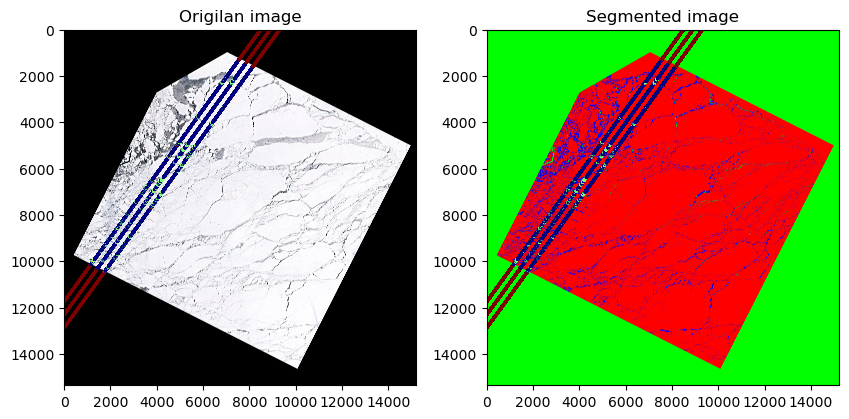

In [13]:
#from rembg import remove
import cv2
import time

path = 's2_tiff/'
#file = 's2_tiff/s2_vis_16_T02CNV_32702.tif' #glob.glob(path + "*_label.tif")[1]
filelist = sorted(glob.glob(path + "s2_vis_" + "*.tif"))
for file in filelist:
    print(file)
    t0 = time.time()
    img = rasterio.open(file, crs = 'EPSG:3976')
    
    raw = img.read(1)
    raw[raw < 0] = 0
    
    ori = img.read()
    ori[ori < 0] = 0
    ori = ori.swapaxes(0,1)
    ori = ori.swapaxes(1,2)

    img_array = shadow_cloud_removal(ori)
    img_array[img_array < 0] = 0
    #img_array = remove(img_array)
    #img_array = rgba2rgb(img_array, background=(0,0,0)) 
    
    height = img_array.shape[0]
    width = img_array.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(img.transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)
    print(xs.shape)
    
    #def calculate_floesize(array, segment, cellsize = 50*50):
    #    if segment != 0:
    #        floesize = len(np.where(array == segment)[0]) * cellsize
    #    else:
    #        floesize = 0
    #    return floesize     
    
    imgfile = os.path.basename(file)[10:-4]
    list03 = pd.read_csv("ATL03_S2_2019-11-01_2019-11-30_ross.csv")

    atlfilepath = "ATL03_Nov_2019_down2023/csv/"
    atlfile = list03[list03['S2_id'] == "COPERNICUS/S2_SR/"+imgfile]['IS2_file'].values[0][:-9]
    
    df_gt1r = pd.DataFrame()
    df_gt2r = pd.DataFrame()
    df_gt3r = pd.DataFrame()
    
    altfile_gt1r = atlfilepath + atlfile + "gt1r.csv"
    if os.path.isfile(altfile_gt1r):
        df_gt1r = pd.read_csv(altfile_gt1r)
        print(altfile_gt1r)
    
    altfile_gt2r = atlfilepath + atlfile + "gt2r.csv"
    if os.path.isfile(altfile_gt2r):
        df_gt2r = pd.read_csv(altfile_gt2r)
        print(altfile_gt2r)
    
    altfile_gt3r = atlfilepath + atlfile + "gt3r.csv"
    if os.path.isfile(altfile_gt3r):
        df_gt3r = pd.read_csv(altfile_gt3r)
        print(altfile_gt3r)
    
    df0 = df_gt1r.append(df_gt2r).append(df_gt3r)
    df0 = df0.reset_index(drop=True)
    
    #break
    
    #df0 = pd.read_csv(atlfilepath + atlfile)
    #beam = 0
    #df0 = get_ATL10data("F:\\IS2_floes\\ATL10\\" + region + "\\" + atlfile, 1000, None)[beam]
    df0['x_atc'] = df0['x']
    df0.drop(['x'], axis = 1)

    gdf = geopandas.GeoDataFrame(df0, geometry=geopandas.points_from_xy(df0.lon, df0.lat))
    gdf.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    gdf = gdf.to_crs('epsg:3976')

    gdf['x'] = gdf.geometry.apply(lambda x: x.x)
    gdf['y'] = gdf.geometry.apply(lambda x: x.y)

    df = pd.DataFrame(gdf)     

    x_min = xs.min()
    x_max = xs.max()
    y_min = ys.min()
    y_max = ys.max()

    #print(x_min, x_max, y_min, y_max)

    df = df[(df["x"]>=x_min) & (df["x"]<=x_max) & (df["y"]>=y_min) & (df["y"]<=y_max)]

    #print(df)

    idx = img.index(df["x"], df["y"])
    df["pix_x"] = idx[1]
    df["pix_y"] = idx[0]
    #df["S2_value"] = raw[idx[0], idx[1]]
    #df["segment"] = array[idx[0], idx[1]]

    #cellsize = 50*50
    #for k in np.unique(df["segment"]):
    #    if k > 0:
    #        floesize = len(np.where(array == k)[0]) * cellsize
    #    else:
    #        floesize = 0
    #    df.loc[df["segment"]==k, "floesize"] = floesize
    #    
    #    if k % 1000 == 0:
    #        print(k)
    #
    #df = df.reset_index(drop = True)
    print("FINISH!!")
    
    
    # R G B => thick ice 0, open water 1, thin ice 2
    rgb_array = img_array[idx[0], idx[1]]
    #print(rgb_array)
    #transform to R B G => thick ice 0, thin ice 1, open water 2
    rgb_array[:, [2, 1]] = rgb_array[:, [1, 2]]
    
    df["label"] = np.argmax(rgb_array, axis=1)
    
    label_path = "ATL03_labeled_data/old/"
    # save the prepared data
    
    print(label_path + atlfile + imgfile[-6:] + "_" + "labeled_old.csv")
    #df.to_csv(label_path + atlfile + imgfile[-6:] + "_" + "labeled_old.csv")
    
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(ori, cv2.COLOR_BGR2RGB))
    plt.scatter(df["pix_x"], df["pix_y"], c = df["label"], s=1, cmap = "jet")
    plt.title("Origilan image")
    plt.subplot(1, 2, 2)
    plt.imshow(img_array, cmap ="gray")
    plt.scatter(df["pix_x"], df["pix_y"], c = df["label"], s=1, cmap = "jet")
    plt.title("Segmented image")
    plt.show()
    
    #debug
    break
    
    t1 = time.time()

    total = t1-t0
    print("time is ", total)

#date = dt.datetime.strptime(os.path.basename(file)[10:18], "%Y%m%d")
#date

## Autolabeleing Process

time is  15.712612867355347


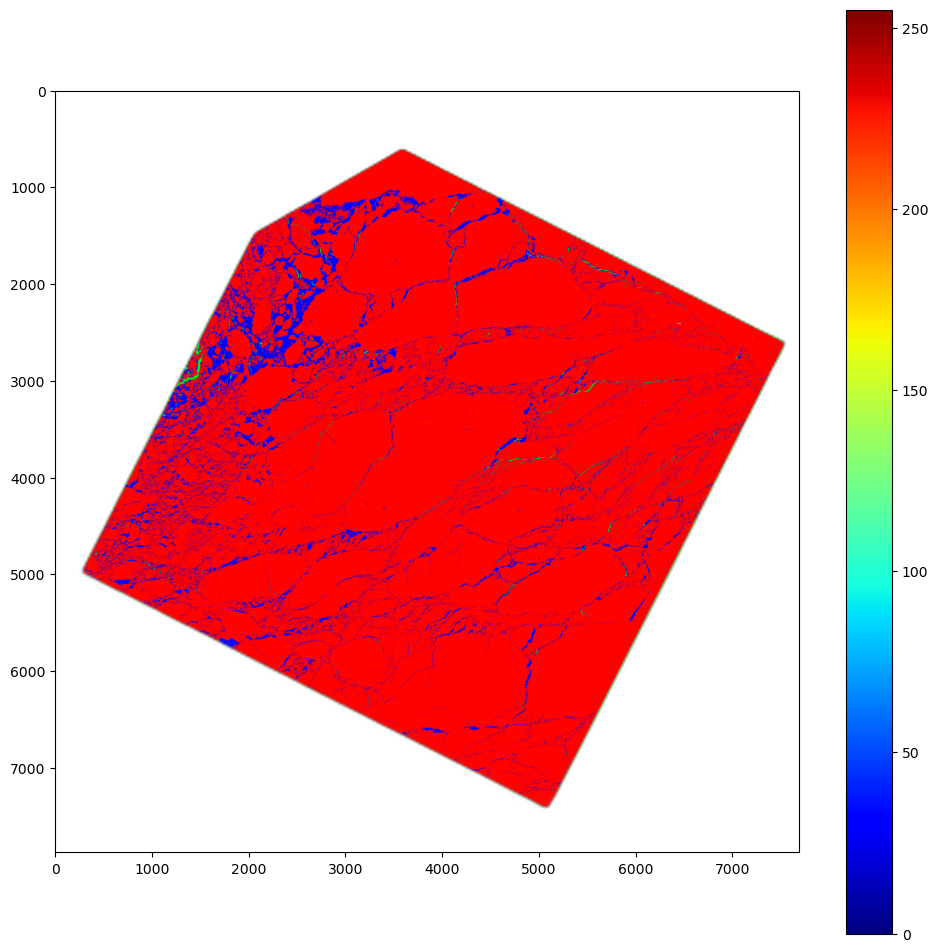

In [16]:
from rembg import remove
import cv2
import time

t0 = time.time()


root = "s2_tiff/"
#ori = cv2.imread(root + "s2_vis_22.png") 
#ori = cv2.imread(root + "s2_vis_16_T02CNV_3976.tif") 
img = rasterio.open(root + "s2_vis_00_20191103T183459_20191103T183502_T05CMR.tif", crs = 'EPSG:3976')
#img_array = img.read(1)
ori = img.read()
ori = ori.swapaxes(0,1)
ori = ori.swapaxes(1,2)

img_array = shadow_cloud_removal(ori)
img_array[img_array < 0] = 0
img_array = remove(img_array)


plt.figure(figsize = (12,12))
plt.imshow(img_array, cmap = "jet")
#plt.imshow(seg_img)
#plt.imshow(ori)
t1 = time.time()

total = t1-t0
print("time is ", total)
plt.colorbar()

## Raw image load

In [17]:
#path = 's2_tiff/'
#file = 's2_tiff/s2_vis_16_T02CNV_32702-0000000000-0000000000.tif' #glob.glob(path + "*_label.tif")[1]
#
##path = "F:\\IS2_floes\\S2\\" + region + "\\"
##file = path + "20220107T103149_20220107T103149_T24CWC.tif" #glob.glob(path + "*.tif")[1]
#
#imgfile = os.path.basename(file)[10:-4]
#imgfile

In [18]:
#img = rasterio.open(file, crs = 'EPSG:3976')
#img = rasterio.open(file, crs = 'EPSG:32702')
img = rasterio.open(root + "s2_vis_07_20191106T184459_20191106T184500_T03CWN.tif", crs = 'EPSG:3976')
raw = img.read(1)
raw[raw < 0] = 0
plt.imshow(raw, cmap = "jet")#, vmin = 0, vmax = 10000)
plt.colorbar()

RasterioIOError: s2_tiff/s2_vis_07_20191106T184459_20191106T184500_T03CWN.tif: No such file or directory

In [ ]:
#height = img_array.shape[0]
#width = img_array.shape[1]
#cols, rows = np.meshgrid(np.arange(width), np.arange(height))
#xs, ys = rasterio.transform.xy(img.transform, rows, cols)
#lons= np.array(xs)
#lats = np.array(ys)
#print('lons shape', lons.shape)

In [19]:
height = img_array.shape[0]
width = img_array.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(img.transform, rows, cols)
xs = np.array(xs)
ys = np.array(ys)
print(xs.shape)

(7874, 7692)


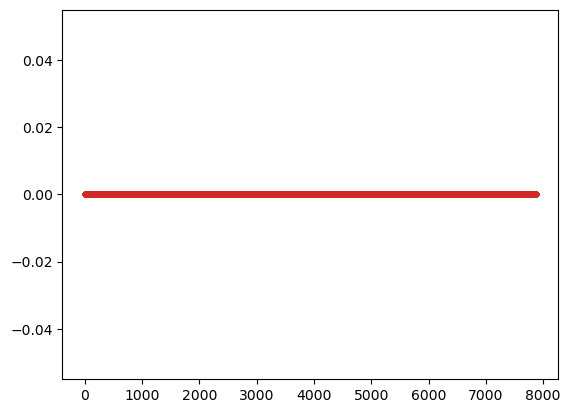

In [20]:
plt.plot(img_array[:, 100], '.')

## Transform CRS code

In [21]:
#import pyproj
#source_crs = 'epsg:32702' # Coordinate system of the file
#target_crs = 'epsg:3976' # Global lat-lon coordinate system
#
#polar_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)

In [22]:
#xs, ys = polar_to_latlon.transform(lons, lats)
#plt.plot(xs, ys)

In [23]:
#plt.plot(ys, xs)

## Read ATL03 files

In [24]:
# make sure we're dealing with the most recent version of any code we're using
%load_ext autoreload
%autoreload 2

#from readers.get_ATL10 import get_ATL10data
#from readers.getATL07 import get_ATL07

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def calculate_floesize(array, segment, cellsize = 50*50):
    if segment != 0:
        floesize = len(np.where(array == segment)[0]) * cellsize
    else:
        floesize = 0
    return floesize     
    

#list10 = pd.read_csv("F:\\IS2_floes\\Overlapped_ATL10_S2_{0}_2018-09-01_2022-03-31_filtered.csv".format(region))
#list10 = pd.read_csv("ATL03_S2_2019-11-01_2019-11-30_ross.csv".format(region))

#atlfile = list10[list10['S2_id'] == "COPERNICUS/S2_SR/"+imgfile]['IS2_file'].values[0]

beam = 0
df0 = pd.read_csv("ATL03_Nov_2019_down2023/csv/ATL03_20191103184432_05780510_gt1r.csv")
#s2 6 => ATL03_20191104195311_05940510_gt2r
#ATL03_20191113191053_07310510_gt1r
#df0 = get_ATL10data("F:\\IS2_floes\\ATL10\\" + region + "\\" + atlfile, 1000, None)[beam]
df0['x_atc'] = df0['x']
df0.drop(['x'], axis = 1)

gdf = geopandas.GeoDataFrame(df0, geometry=geopandas.points_from_xy(df0.lon, df0.lat))
gdf.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
gdf = gdf.to_crs('epsg:3976')

gdf['x'] = gdf.geometry.apply(lambda x: x.x)
gdf['y'] = gdf.geometry.apply(lambda x: x.y)

df = pd.DataFrame(gdf)     

#print(df['x'], df['y'])

x_min = xs.min()
x_max = xs.max()
y_min = ys.min()
y_max = ys.max()

print(x_min, x_max, y_min, y_max)

df = df[(df["x"]>=x_min) & (df["x"]<=x_max) & (df["y"]>=y_min) & (df["y"]<=y_max)]

#print(df)

idx = img.index(df["x"], df["y"])
df["pix_x"] = idx[1]
df["pix_y"] = idx[0]
#df["S2_value"] = raw[idx[0], idx[1]]
#df["segment"] = array[idx[0], idx[1]]

#cellsize = 50*50
#for k in np.unique(df["segment"]):
#    if k > 0:
#        floesize = len(np.where(array == k)[0]) * cellsize
#    else:
#        floesize = 0
#    df.loc[df["segment"]==k, "floesize"] = floesize
#    
#    if k % 1000 == 0:
#        print(k)
#
#df = df.reset_index(drop = True)
print("FINISH!!")

-721530.0 -567710.0 -1442130.0 -1284670.0
FINISH!!


In [26]:
# R G B => thick ice 0, open water 1, thin ice 2
rgb_array = img_array[idx[0], idx[1]]
print(rgb_array)
#transform to R B G => thick ice 0, thin ice 1, open water 2
rgb_array[:, [2, 1]] = rgb_array[:, [1, 2]]
#print(l)

df["label"] = np.argmax(rgb_array, axis=1)
print(df["label"])

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
171402    0
171403    0
171404    0
171405    0
171406    0
         ..
247284    0
247285    0
247286    0
247287    0
247288    0
Name: label, Length: 75887, dtype: int64


In [ ]:
df

In [ ]:
#fields = ["S2_value", "freeboard", "lead", "segment", "floesize"]
#num = len(fields)
#
#fig, ax = plt.subplots(num,1, sharex = True, figsize = (10, num*2))
#for i in range(0, len(fields)):
#    ax[i].plot(df["x_atc"]/1000, df[fields[i]], '.')
#

In [22]:
#plt.scatter(np.log(df["floesize"]), df["freeboard"])

In [23]:
#np.corrcoef(np.log(df["floesize"]), df["freeboard"])

In [24]:
#idx = img.index(df["x"], df["y"])
#print(idx)
#df["pix_x"] = idx[1]
#df["pix_y"] = idx[0]

In [14]:
##plt.figure(figsize = (15, 15))
##plt.imshow(raw, vmin = 0, vmax = 10000, cmap ="gray")
##plt.scatter(df["pix_x"], df["pix_y"], c = df["h_cor_mean"], vmin = 0, vmax = 1, s=2, cmap = "jet")
#
#plt.figure(figsize=(10,10))
#plt.subplot(1, 2, 1)
#plt.imshow(raw, cmap ="gray")
#plt.scatter(df["pix_x"], df["pix_y"], c = df["label"], s=1, cmap = "jet")
#plt.title("Origilan image")
#plt.subplot(1, 2, 2)
#plt.imshow(img_array, cmap ="gray")
#plt.scatter(df["pix_x"], df["pix_y"], c = df["label"], s=1, cmap = "jet")
#plt.title("Segmented image")
#plt.show()

In [15]:
#plt.figure(figsize = (15, 15))
#plt.imshow(img_array, cmap ="gray")
#plt.scatter(df["pix_x"], df["pix_y"], c = df["label"], s=2, cmap = "jet")
#
#plt.figure(figsize = (15, 15))
#plt.imshow(img_array, cmap ="gray")
#plt.scatter(df["pix_x"], df["pix_y"], c = df["h_cor_med"], s=2, cmap = "jet")
#
#plt.figure(figsize = (15, 15))
#plt.imshow(img_array, cmap ="gray")
#plt.scatter(df["pix_x"], df["pix_y"], c = df["h_cor_mean"], s=2, cmap = "jet")
#
#
#plt.figure(figsize = (15, 15))
#plt.imshow(raw, cmap ="gray")
#plt.scatter(df["pix_x"], df["pix_y"], c = df["label"], s=2, cmap = "jet")

## Regional comparison

In [ ]:
step = 50
r = 100
cellsize = 50*50

mean_fb = np.array([np.arange(0, 10)])
mean_fs = np.array([np.arange(0, 10)])
std_fb = np.array([])
std_fs= np.array([])

for i in range(0, len(df), step):
    xc = df["pix_x"][i]
    yc = df["pix_y"][i]
    subset = array[yc-r:yc+r, xc-r:xc+r]

    floesizes = np.array([])
    
    idx = (df["x_atc"]>=df["x_atc"][i]-r*50) & (df["x_atc"]<=df["x_atc"][i]+r*50) & (df["lead"] == 0)
    
    for k in np.unique(subset):
        if k > 0:
            floesize = len(np.where(array == k)[0]) * cellsize
            floesizes = np.append(floesizes, floesize)
    
    q_fs = np.array([np.zeros(10) * np.nan])
    q_fb = np.array([np.zeros(10) * np.nan])
    
    if len(floesizes) > 0:
        for q in np.arange(0, 10):
            q_fs[0, q] = np.quantile(floesizes, q*0.1)
            q_fb[0, q] = np.quantile(df.loc[idx,"freeboard"], q*0.1)

        mean_fs = np.concatenate((mean_fs, q_fs), axis = 0)
        mean_fb = np.concatenate((mean_fb, q_fb), axis = 0)

        std_fs = np.append(std_fs, np.nanstd(floesizes))
        std_fb = np.append(std_fb, df.loc[idx].std()["freeboard"])
    
    if i % 1000 == 0:
        print(i)

mean_fs = mean_fs[1:, :]
mean_fb = mean_fb[1:, :]

print("FINISH")

In [ ]:
print(np.shape(mean_fs))
print(np.shape(q_fs))

In [ ]:
np.quantile(df.loc[idx]["freeboard"], 0.9)

In [ ]:
(df["x_atc"]>=df["x_atc"][i]-r*50) & (df["x_atc"]<=df["x_atc"][i]+r*50)

In [ ]:
for k in [5]:
    plt.scatter(np.log(mean_fs[:, k]), mean_fb[:, k])
#     print(np.corrcoef(np.log(mean_fs[:, 4]), mean_fb[:, k])[0][1])
# plt.ylim(0,3)
plt.xlabel("Floe size")
plt.ylabel("Freeboard")

In [ ]:
plt.scatter(np.log(mean_fs[:, 5]), std_fb)

In [ ]:
mean_fs[:, 4]

In [ ]:
# Create sampling points
points = [Point(625466, 5621289), Point(626082, 5621627), Point(627116, 5621680), Point(625095, 5622358)]
gdf = geopandas.GeoDataFrame([1, 2, 3, 4], geometry=points, crs=32630)

In [ ]:
src = rasterio.open('s2a_l2a_fishbourne.tif')

In [ ]:
from rasterio.plot import show

fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='pink')

gdf.plot(ax=ax)

In [ ]:
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]

In [ ]:
gdf['value'] = [x for x in src.sample(coord_list)]
gdf.head()